In [1]:
import sys
!{sys.executable} -m pip install gitpython
!{sys.executable} -m pip install pyvis
from pathlib import Path
from collections import defaultdict

import networkx as nx
import matplotlib.pyplot as plt

# all the needed imports
import os
import sys
import re


from git import Repo

# ──────────────────────────────────────────────────────────────────────────────
# Helpers: module names & imports
# ──────────────────────────────────────────────────────────────────────────────

def module_name_from_file_path(fp: str) -> str:
    p = Path(fp)
    parts = list(p.parts)
    idx = parts.index("zeeguu")
    mod = parts[idx:]
    mod[-1] = mod[-1].replace(".py", "")
    return ".".join(mod)

def imports_from_file(fp: str) -> list[str]:
    imps = set()
    for line in open(fp, encoding="utf8"):
        line = line.strip()
        if line.startswith("import "):
            imps.add(line.split()[1])
        elif line.startswith("from "):
            imps.add(line.split()[1])
    return list(imps)


In [2]:
cwd = os.getcwd()
print(cwd)

/Users/christianlauridsen/Documents/ITU/MSc/semester-2/Software-Architecture/architectural-reconstruction


In [5]:
def build_raw_graph(code_root: Path) -> nx.DiGraph:
    G = nx.DiGraph()
    for py in code_root.rglob("*.py"):
        src = module_name_from_file_path(str(py))
        if not src.startswith("zeeguu.core"):
            continue
        G.add_node(src)
        for tgt in imports_from_file(str(py)):
            if tgt.startswith("zeeguu.core"):
                G.add_node(tgt)
                G.add_edge(src, tgt)
    return G

# Example usage: adjust the path to your project root

CODE_ROOT = Path(cwd+"/content/zeeguu-api/zeeguu/core")
print(f"Code root: {CODE_ROOT}")
rawG = build_raw_graph(CODE_ROOT)
print(f"Raw graph: {rawG.number_of_nodes()} nodes, {rawG.number_of_edges()} edges")


Code root: /Users/christianlauridsen/Documents/ITU/MSc/semester-2/Software-Architecture/architectural-reconstruction/content/zeeguu-api/zeeguu/core
Raw graph: 246 nodes, 620 edges


In [6]:
def top_level_module(mod: str, depth: int = 3) -> str:
    parts = mod.split(".")
    return ".".join(parts[:depth])

def build_weighted_graph(G: nx.DiGraph,
                         depth: int = 3,
                         min_weight: int = 2) -> nx.DiGraph:
    counts = defaultdict(int)
    for u, v in G.edges():
        su = top_level_module(u, depth)
        sv = top_level_module(v, depth)
        if su == sv:
            continue
        if "exercises" in su or "exercises" in sv:
            continue
        if "test" in su or "test" in sv:
            continue
        counts[(su, sv)] += 1

    H = nx.DiGraph()
    for (su, sv), w in counts.items():
        if w >= min_weight:
            H.add_edge(su, sv, weight=w)

    # drop isolates
    for n in list(H.nodes()):
        if H.degree(n) == 0:
            H.remove_node(n)

    return H

weightedG = build_weighted_graph(rawG, depth=3, min_weight=2)
print(f"Weighted & pruned: {weightedG.number_of_nodes()} nodes, {weightedG.number_of_edges()} edges")


Weighted & pruned: 18 nodes, 30 edges


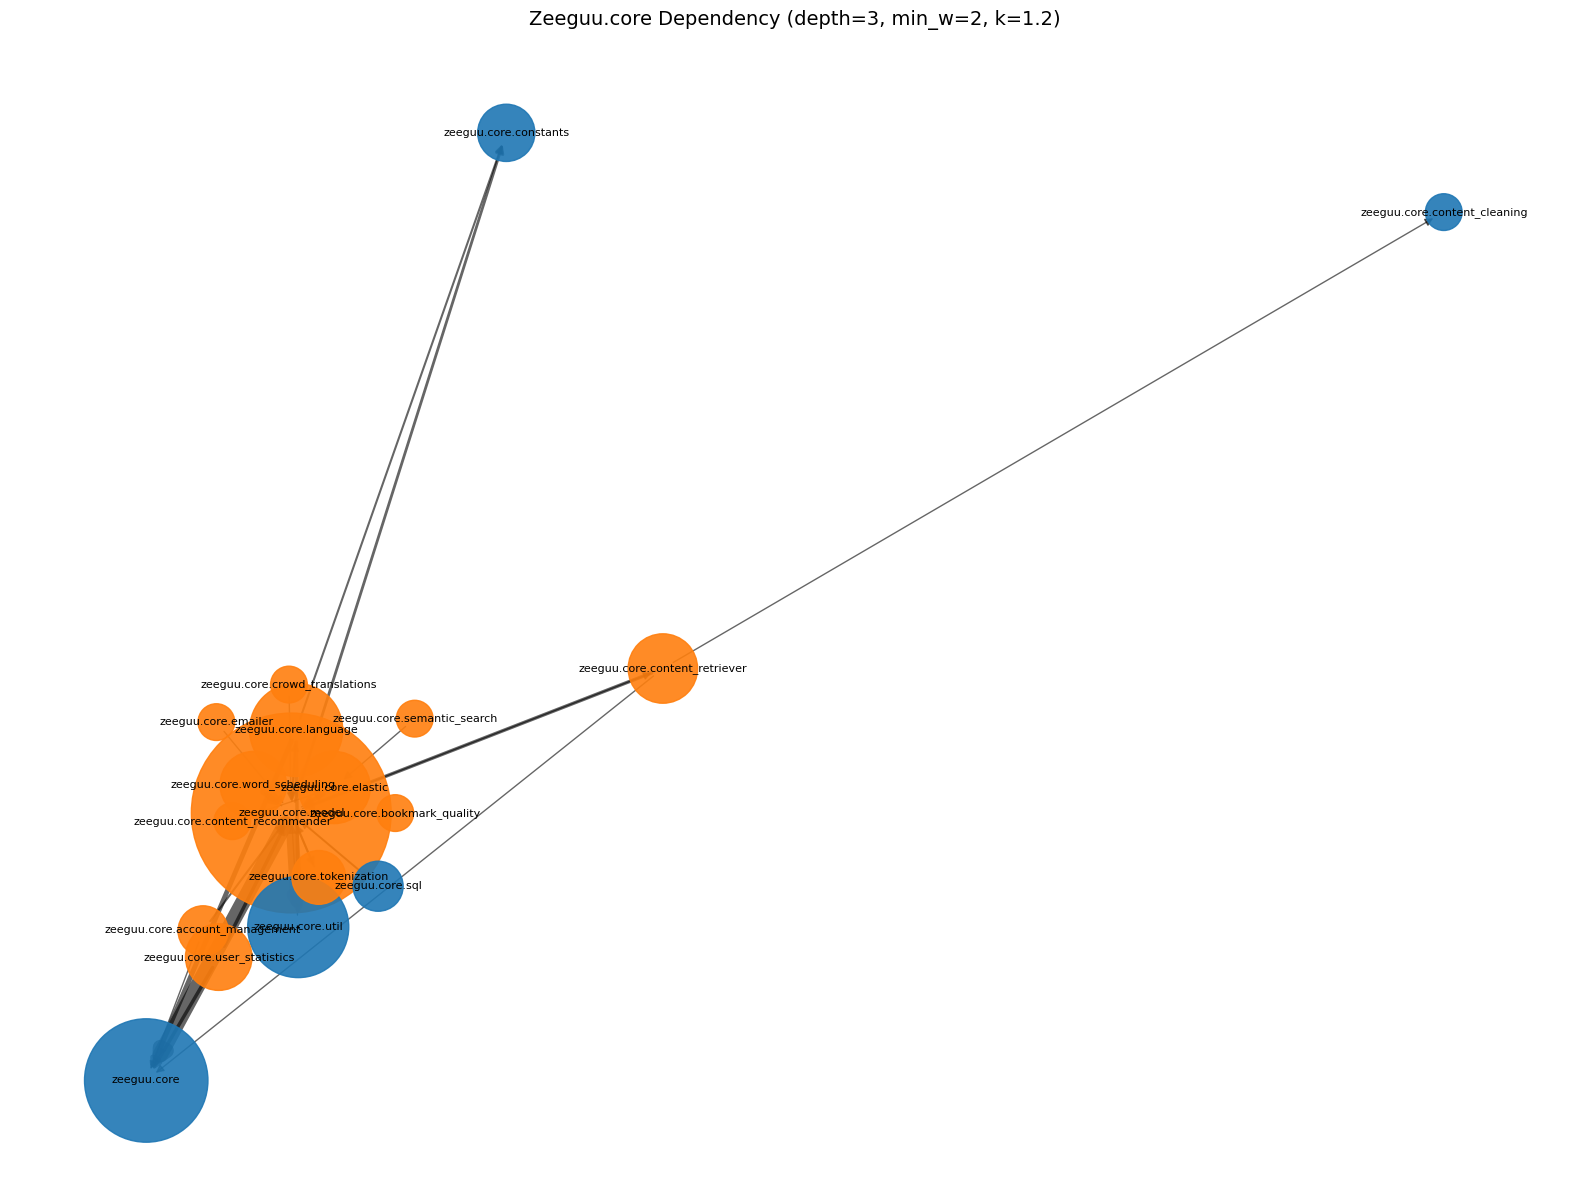

In [7]:
def draw_graph(G: nx.DiGraph, figsize=(14,10), k=1.0, iterations=200):
    pos = nx.spring_layout(G, k=k, iterations=iterations)

    # style
    node_sizes, node_colors = [], []
    for n in G.nodes():
        indeg = G.in_degree(n, weight="weight")
        outdeg = G.out_degree(n, weight="weight")
        tot = indeg + outdeg
        node_sizes.append(300 + 200 * tot)
        node_colors.append("C0" if indeg > outdeg else "C1")

    edge_widths = [max(1.0, d["weight"] / 2) for _, _, d in G.edges(data=True)]

    plt.figure(figsize=figsize)
    nx.draw_networkx_nodes(G, pos,
                           node_size=node_sizes,
                           node_color=node_colors,
                           alpha=0.9)
    nx.draw_networkx_edges(G, pos,
                           width=edge_widths,
                           alpha=0.6,
                           arrowsize=12)
    nx.draw_networkx_labels(G, pos,
                            font_size=8)
    plt.title(f"Zeeguu.core Dependency (depth=3, min_w=2, k={k})", fontsize=14)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Finally, render it:
draw_graph(weightedG, figsize=(16,12), k=1.2, iterations=300)


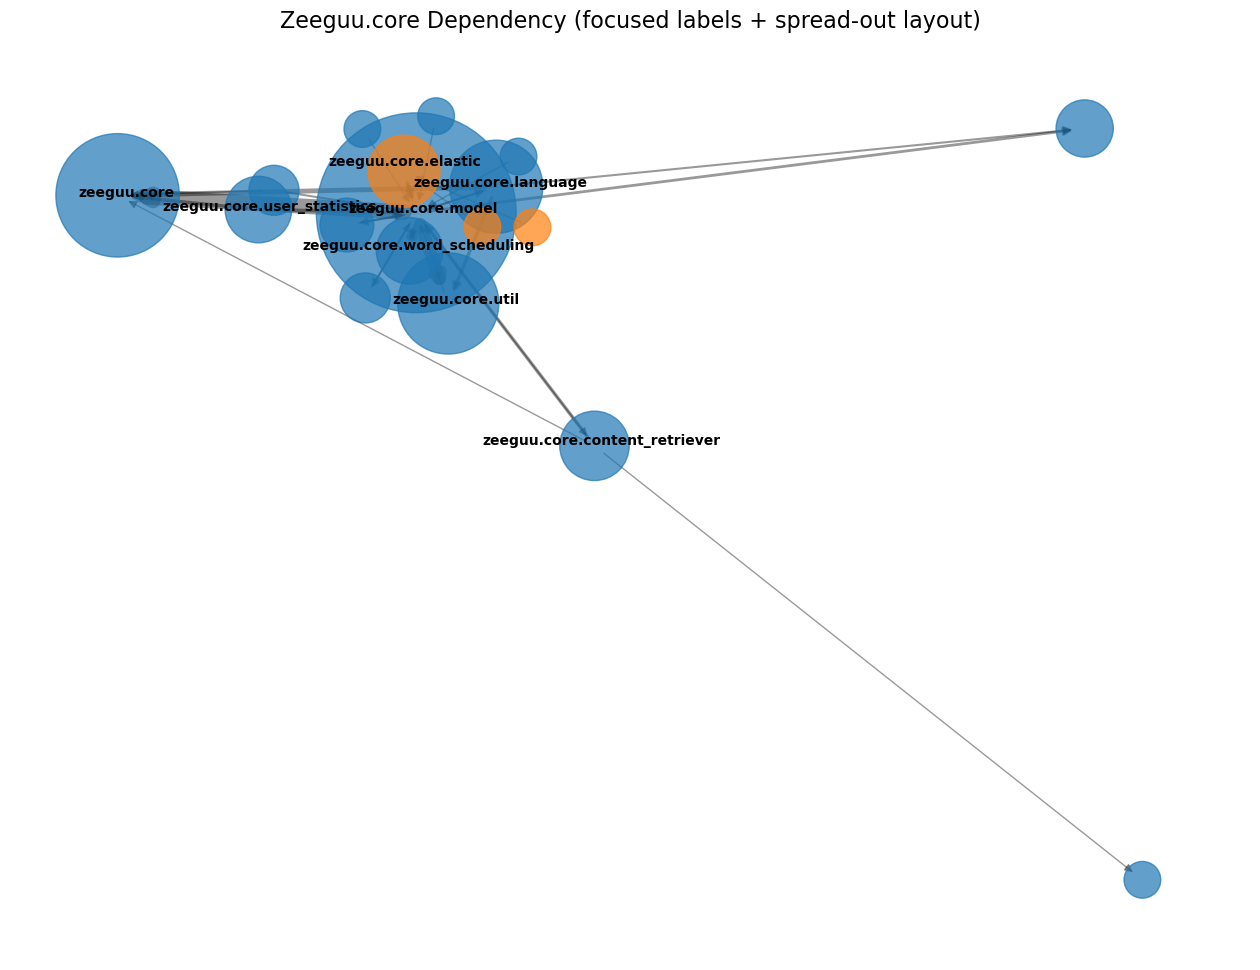

In [8]:
import random
from networkx.algorithms import community

# 1) pick k & iterations for maximum spread
pos = nx.spring_layout(weightedG, k=2.5, iterations=500)

# 2) pick top hubs to label
deg = {n: weightedG.in_degree(n, weight="weight") + weightedG.out_degree(n, weight="weight")
       for n in weightedG.nodes()}
top_nodes = set(sorted(deg, key=lambda n: deg[n], reverse=True)[:8])

# 3) community color‐coding (optional)
comm = next(community.girvan_newman(weightedG))
cluster_map = {n: idx for idx, group in enumerate(comm) for n in group}
node_colors = [f"C{cluster_map[n] % 10}" for n in weightedG.nodes()]

# 4) draw
plt.figure(figsize=(16,12))
nx.draw_networkx_nodes(weightedG, pos,
                       node_size=[300+200*deg[n] for n in weightedG.nodes()],
                       node_color=node_colors,
                       alpha=0.7)
nx.draw_networkx_edges(weightedG, pos,
                       width=[max(1, d["weight"]/2) for *_, d in weightedG.edges(data=True)],
                       alpha=0.4,
                       arrowsize=12)

# 5) jittered labels for only the top modules
labels = {n: n for n in top_nodes}
label_pos = {n: (pos[n][0] + 0.02*random.random(),
                 pos[n][1] + 0.02*random.random())
             for n in top_nodes}
nx.draw_networkx_labels(weightedG, label_pos,
                        labels=labels,
                        font_size=10,
                        font_weight="bold")

plt.title("Zeeguu.core Dependency (focused labels + spread-out layout)", fontsize=16)
plt.axis("off")
plt.show()


In [10]:
from pyvis.network import Network

# `weightedG` is your pruned+aggregated nx.DiGraph
net = Network(
    height="800px", width="100%",
    bgcolor="#ffffff", font_color="black",
    notebook=True, directed=True, cdn_resources='in_line'
)

# add nodes, size by degree
for n in weightedG.nodes():
    tot = weightedG.in_degree(n, weight="weight") + weightedG.out_degree(n, weight="weight")
    net.add_node(n, 
                 label=n,        # label shown on hover
                 title=f"{n}<br>in:{weightedG.in_degree(n,weight='weight')} out:{weightedG.out_degree(n,weight='weight')}",
                 value=tot,      # node size
                 physics=True)

# add edges, width by weight
for u, v, w in weightedG.edges(data="weight"):
    net.add_edge(u, v, value=w)

# tune physics so nodes spread out
net.repulsion(node_distance=200, central_gravity=0.3)

# show inline in Jupyter
net.show("zeeguu_core.html")


zeeguu_core.html
